In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.utils as vutils
import matplotlib.animation as animation
from IPython.display import HTML
import os

# for dirname, _, filenames in os.walk('/kaggle/input/pokemon-images-dataset'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [2]:
dir_jpg = '../input/pokemon-images-dataset/pokemon_jpg/pokemon_jpg/'
dir_png = '../input/pokemon-images-dataset/pokemon/pokemon/'
print(len([name for name in os.listdir(dir_jpg) if os.path.isfile(os.path.join(dir_jpg, name))]))
print(len([name for name in os.listdir(dir_png) if os.path.isfile(os.path.join(dir_png, name))]))

819
819


<Figure size 432x288 with 0 Axes>

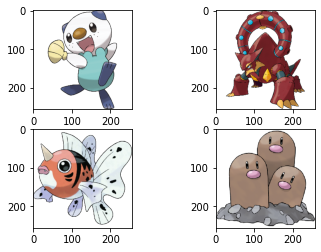

In [3]:
plt.figure()
f, axarr = plt.subplots(2, 2)
axarr[0][0].imshow(plt.imread('../input/pokemon-images-dataset/pokemon/pokemon/501.png'))
axarr[0][1].imshow(plt.imread('../input/pokemon-images-dataset/pokemon/pokemon/721.png'))
axarr[1][0].imshow(plt.imread('../input/pokemon-images-dataset/pokemon/pokemon/119.png'))
axarr[1][1].imshow(plt.imread('../input/pokemon-images-dataset/pokemon/pokemon/51.png'))

# Initialization

In [4]:
DIR = '../input/pokemon-images-dataset/pokemon/'
SHAPE = 64
BATCH = 16
NORM_MEAN, NORM_STD = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
GEN_INP = 100
GEN_OUT = 64
DISC_INP = 64
NUM_CHAN = 3
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
LR = 2E-4
EPOCHS = 50

# Data Augmentation

In [5]:
from torch.utils.data import DataLoader, ConcatDataset
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [6]:
orig_ds = ImageFolder(DIR, transform = T.Compose([
                T.Resize(SHAPE),
                T.CenterCrop(SHAPE),
                T.ToTensor(),
                T.Normalize(mean = NORM_MEAN, std = NORM_STD)]))

mirrored_ds = ImageFolder(DIR, transform = T.Compose([
                T.Resize(SHAPE),
                T.CenterCrop(SHAPE),
                T.RandomHorizontalFlip(p=1.),
                T.ToTensor(),
                T.Normalize(mean = NORM_MEAN, std = NORM_STD)]))

color_jitter_ds = ImageFolder(DIR, transform = T.Compose([
                T.Resize(SHAPE),
                T.CenterCrop(SHAPE),
                T.ColorJitter(0.5,  0.5, 0.5),
                T.ToTensor(),
                T.Normalize(mean = NORM_MEAN, std = NORM_STD)]))

dataset = ConcatDataset([orig_ds, mirrored_ds, color_jitter_ds])
dataloader = DataLoader(dataset, BATCH, shuffle = True, num_workers = 4, pin_memory = False)

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [7]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Generator Module

In [8]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # 100 x 1 x 1
                        nn.ConvTranspose2d(in_channels=GEN_INP, out_channels=GEN_OUT*8,
                            kernel_size=4, stride=1, padding=0, bias=False),
                        nn.BatchNorm2d(num_features=GEN_OUT*8),
                        nn.ReLU(True),
            # 512 x 4 x 4
                        nn.ConvTranspose2d(GEN_OUT*8, GEN_OUT*4, 4, 2, 1, bias=False),
                        nn.BatchNorm2d(GEN_OUT*4),
                        nn.ReLU(True),
            # 256 x 8 x 8
                        nn.ConvTranspose2d(GEN_OUT*4, GEN_OUT*2, 4, 2, 1, bias=False),
                        nn.BatchNorm2d(GEN_OUT*2),
                        nn.ReLU(True),
            # 128 x 16 x 16
                        nn.ConvTranspose2d(GEN_OUT*2, GEN_OUT, 4, 2, 1, bias=False),
                        nn.BatchNorm2d(GEN_OUT),
                        nn.ReLU(True),     
            # 64 x 32 x 32
                        nn.ConvTranspose2d(GEN_OUT, NUM_CHAN, 4, 2, 1, bias=False),
                        nn.Tanh()
            # 3 x 64 x 64
                    )
    
    def forward(self, input):
            return self.main(input)

In [9]:
gen = Generator().to(DEVICE)
gen.apply(weights_init)
print(gen)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


# Discriminator Module

In [10]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # 3 x 64 x 64
                        nn.Conv2d(in_channels=NUM_CHAN, out_channels=SHAPE, kernel_size=4, 
                            stride=2, padding=1, bias=False),
                        nn.LeakyReLU(0.2, inplace=True),
            # 64 x 32 x 32
                        nn.Conv2d(SHAPE, SHAPE*2, 4, 2, 1, bias=False),
                        nn.BatchNorm2d(SHAPE*2),
                        nn.LeakyReLU(0.2, inplace=True),
            # 128 x 16 x 16
                        nn.Conv2d(SHAPE*2, SHAPE*4, 4, 2, 1, bias=False),
                        nn.BatchNorm2d(SHAPE*4),
                        nn.LeakyReLU(0.2, inplace=True),
            # 256 x 8 x 8
                        nn.Conv2d(SHAPE*4, SHAPE*8, 4, 2, 1, bias=False),
                        nn.BatchNorm2d(SHAPE*8),
                        nn.LeakyReLU(0.2, inplace=True),
            # 512 x 4 x 4
                        nn.Conv2d(SHAPE*8, 1, 4, 1, 0, bias=False),
                        nn.Sigmoid()
            )
        
    def forward(self, input):
        return self.main(input)

In [11]:
disc = Discriminator().to(DEVICE)
disc.apply(weights_init)
print(disc)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [12]:
criterion = nn.BCELoss()

fixed_noise = torch.randn(64, 100, 1, 1, device=DEVICE)

real_label = 1.
fake_label = 0.

optimDisc = torch.optim.Adam(disc.parameters(), lr=LR, betas=(0.5, 0.999))
optimGen = torch.optim.Adam(gen.parameters(), lr=LR, betas=(0.5, 0.999))

In [13]:
img_list, G_loss, D_loss = [], [], []
n_iter = 0

print("---------Train Loop---------")
for epoch in range(EPOCHS):
    for i, data in enumerate(dataloader, 0):
        
        disc.zero_grad()
        real_cpu = data[0].to(DEVICE)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=DEVICE)
        # Forward pass real batch through D
        output = disc(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, 100, 1, 1, device=DEVICE)
        # Generate fake image batch with G
        fake = gen(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = disc(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimDisc.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        gen.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = disc(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimGen.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, EPOCHS, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_loss.append(errG.item())
        D_loss.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (n_iter % 500 == 0) or ((epoch == EPOCHS-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = gen(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        n_iter += 1


---------Train Loop---------
[0/50][0/154]	Loss_D: 2.0896	Loss_G: 7.2914	D(x): 0.6500	D(G(z)): 0.7236 / 0.0010
[0/50][50/154]	Loss_D: 0.5231	Loss_G: 19.8062	D(x): 0.7378	D(G(z)): 0.0000 / 0.0000
[0/50][100/154]	Loss_D: 1.4556	Loss_G: 4.9477	D(x): 0.6882	D(G(z)): 0.5177 / 0.0118
[0/50][150/154]	Loss_D: 0.3277	Loss_G: 2.7709	D(x): 0.8094	D(G(z)): 0.0730 / 0.0828
[1/50][0/154]	Loss_D: 0.2485	Loss_G: 6.5662	D(x): 0.8094	D(G(z)): 0.0102 / 0.0032
[1/50][50/154]	Loss_D: 0.1902	Loss_G: 4.0639	D(x): 0.9650	D(G(z)): 0.1286 / 0.0257
[1/50][100/154]	Loss_D: 0.4503	Loss_G: 8.2417	D(x): 0.9237	D(G(z)): 0.2742 / 0.0003
[1/50][150/154]	Loss_D: 2.8364	Loss_G: 0.8883	D(x): 0.1709	D(G(z)): 0.0433 / 0.5490
[2/50][0/154]	Loss_D: 0.7618	Loss_G: 5.9217	D(x): 0.9853	D(G(z)): 0.4417 / 0.0050
[2/50][50/154]	Loss_D: 0.8254	Loss_G: 5.1440	D(x): 0.8216	D(G(z)): 0.2791 / 0.0078
[2/50][100/154]	Loss_D: 0.8107	Loss_G: 4.3214	D(x): 0.8024	D(G(z)): 0.3996 / 0.0239
[2/50][150/154]	Loss_D: 0.5345	Loss_G: 5.1415	D(x): 0.8

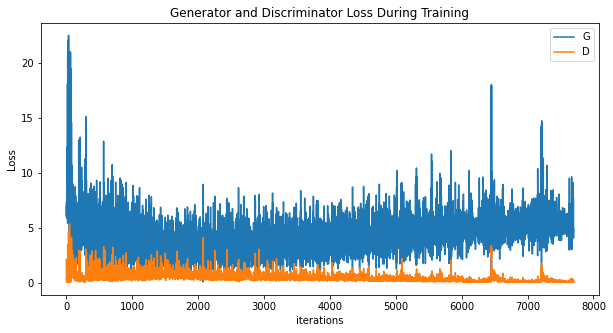

In [14]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_loss,label="G")
plt.plot(D_loss,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

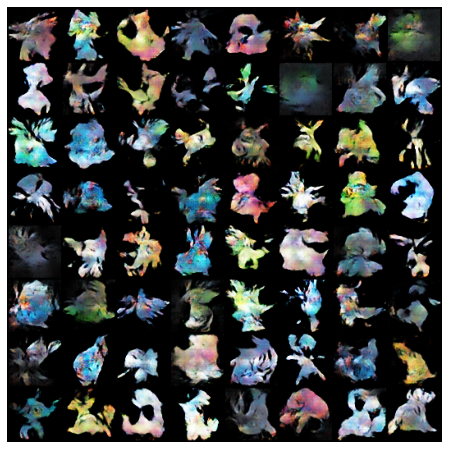

In [15]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


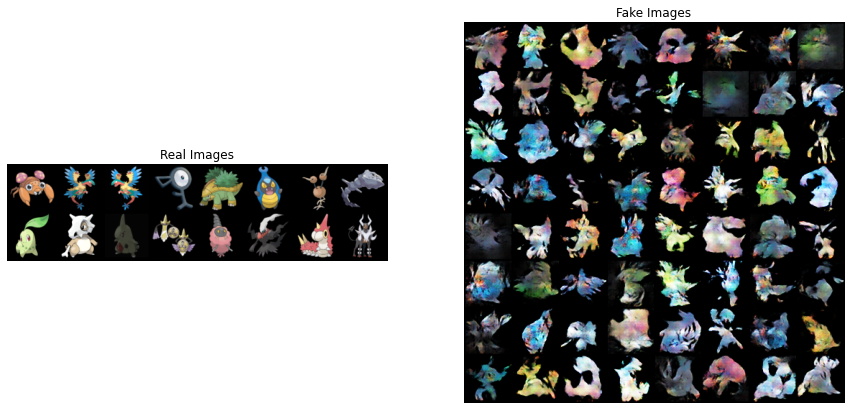

In [16]:
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(DEVICE)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()
